In [1]:
import os
import importlib
import time

import numpy as np
import pandas as pd

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import skimage

import torch
import torch.nn as nn
import torch.optim as optim

import load_data
#import first_exp_model_with_pytorch as dloader
#import first_exp_model_with_pytorch

In [2]:
plt.style.use('Solarize_Light2')
%matplotlib inline
importlib.reload(load_data)

<module 'load_data' from '/home/uldo/work/kaggle/competitions/Human_Protein_Atlas_Image_Classification/code/load_data.py'>

In [3]:
W = H = 512

LABEL_NAMES_MAP = {
    0:  "Nucleoplasm",  
    1:  "Nuclear membrane",   
    2:  "Nucleoli",   
    3:  "Nucleoli fibrillar center",   
    4:  "Nuclear speckles",
    5:  "Nuclear bodies",   
    6:  "Endoplasmic reticulum",   
    7:  "Golgi apparatus",   
    8:  "Peroxisomes",   
    9:  "Endosomes",   
    10:  "Lysosomes",   
    11:  "Intermediate filaments",   
    12:  "Actin filaments",   
    13:  "Focal adhesion sites",   
    14:  "Microtubules",   
    15:  "Microtubule ends",   
    16:  "Cytokinetic bridge",   
    17:  "Mitotic spindle",   
    18:  "Microtubule organizing center",   
    19:  "Centrosome",   
    20:  "Lipid droplets",   
    21:  "Plasma membrane",   
    22:  "Cell junctions",   
    23:  "Mitochondria",   
    24:  "Aggresome",   
    25:  "Cytosol",   
    26:  "Cytoplasmic bodies",   
    27:  "Rods & rings"
}

In [4]:
def show(image, labels):
    f, (ax1,ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(25,25), sharey=True)

    title = ''
    #npimage = image.numpy()[:, ::-1, :, :]
    #print(image.size())
    #print(labels)
    #print(labels.size())
    #print(image)
    npimage = image.numpy()
    nplabels = labels.numpy()
    print(npimage.shape)
    print(nplabels)
    #transposed_npimage = np.transpose(npimage, (1, 2, 0))
    
    #print(transposed_npimage.shape)
    
    #labels =sample['target']
                
    #for i, label in enumerate(LABELS):
    #    if labels[i] == 1:
    #        if title == '':
    #            title += label
    #        else:
    #            title += " & " + label
    
    #for i, label in enumerate(nplabels[0]):
    for i, label in enumerate(nplabels):
        if label == 1:
            if title == '':
                title += LABEL_NAMES_MAP[i]
            else:
                title += " & " + LABEL_NAMES_MAP[i]
    
    ax1.imshow(npimage[0,:,:],cmap="hot")
    ax1.set_title('Red')
    ax2.imshow(npimage[1,:,:],cmap="copper")
    ax2.set_title('Green')
    ax3.imshow(npimage[2,:,:],cmap="bone")
    ax3.set_title('Blue')
    ax4.imshow(npimage[3,:,:],cmap="afmhot")
    ax4.set_title('Yellow')
    f.suptitle(title, fontsize=20, y=0.62)
    

In [5]:
class HPA_ConvNeuralNet(nn.Module):
    
    def __init__(self):
        super(HPA_ConvNeuralNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(4, 8, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(8, 16, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.drop_out = nn.Dropout()
        self.out1 = nn.Linear(int(16 * W/4 * H/4), 900)
        self.out2 = nn.Linear(900, 28)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        output = self.drop_out(x)
        output = self.out1(x)
        output = self.out2(output)
        #return output, x
        return output

In [6]:
train_df = load_data.load_text_data('../input/train.csv')

In [7]:
print(train_df.shape)

(31072, 2)


In [9]:
#train_dataset = dloader.HumanProteinAtlasDataset(train_df, transform=dloader.transforms.ToTensor)
train_dataset = load_data.HumanProteinAtlasDataset(
    train_df.iloc[:10000],
    transform=load_data.transforms.ToTensor()
)

In [10]:
#train_loader = dloader.data.DataLoader(dataset, batch_size=10, shuffle=True, num_workers=1)
train_loader = load_data.data.DataLoader(train_dataset, batch_size=200, shuffle=True, num_workers=1)

In [11]:
print(train_loader)

In [12]:
train_iter = iter(train_loader)

In [13]:
print(type(train_iter))

<class 'torch.utils.data.dataloader._DataLoaderIter'>


In [14]:
images, labels = train_iter.next()

In [15]:
print("images shape on batch size = {}".format(images.size()))
print("labels shape on batch size = {}".format(labels.size()))

images shape on batch size = torch.Size([200, 4, 512, 512])
labels shape on batch size = torch.Size([200, 28])


In [16]:
#import torchvision

In [17]:
#grid = torchvision.utils.make_grid(images)
#grid = torchvision.utils.make_grid([image[0] for image in images])

In [18]:
#plt.imshow(grid)
#plt.axis('off')
#plt.title(labels.numpy())

(4, 512, 512)
[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


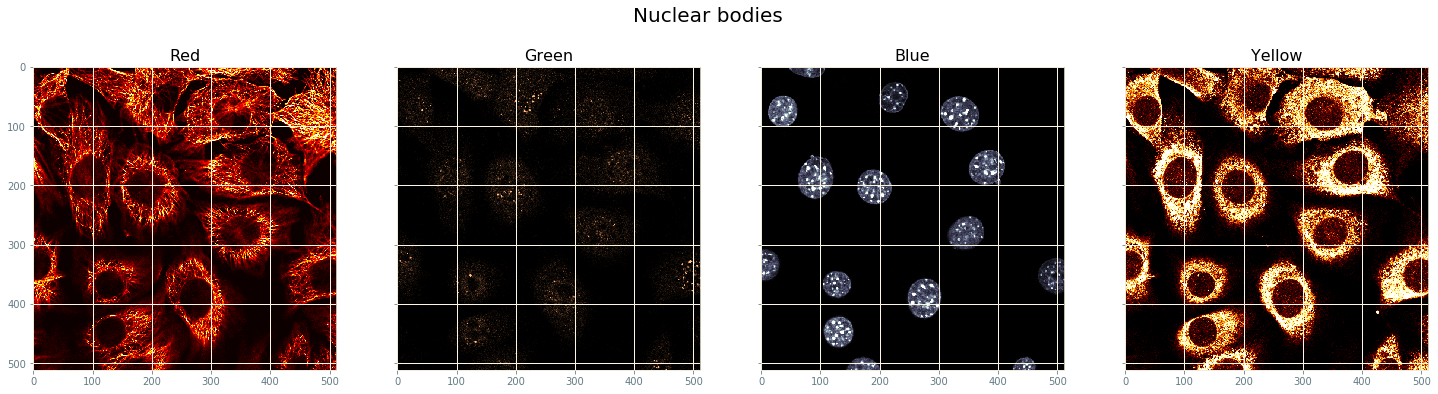

In [19]:
show(images[0], labels[0])

In [20]:
hpa_conv_neural_net = HPA_ConvNeuralNet()

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [22]:
print(device)

cuda:0


In [23]:
hpa_conv_neural_net.to(device)

HPA_ConvNeuralNet(
  (conv1): Sequential(
    (0): Conv2d(4, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop_out): Dropout(p=0.5)
  (out1): Linear(in_features=262144, out_features=900, bias=True)
  (out2): Linear(in_features=900, out_features=28, bias=True)
)

In [24]:
#criterion = nn.CrossEntropyLoss()
criterion=nn.BCEWithLogitsLoss(reduction='sum')
optimizer = optim.SGD(hpa_conv_neural_net.parameters(), lr=0.001, momentum=0.9)

In [25]:
since = time.time()
for epoch in range(2):
    
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data
        inputs, labels = inputs.to(device,dtype=torch.float), labels.to(device,dtype=torch.float)
        #print(inputs)
        #labels = labels[0]
        
        optimizer.zero_grad()
        
        outputs = hpa_conv_neural_net(inputs)
        #print("type(outputs): ", type(outputs))
        #print("outputs.size(): ", outputs.size())
        #print("labels.size(): ", labels.size())
        #loss = criterion(outputs, labels.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if i % 200 == 199:
            print("[%d, %5d, loss: %.3f]" % (epoch + 1, i + 1, running_loss / 20.0))
            running_loss = 0.0
            
print("Finished Training")
time_elapsed = time.time() - since
print(
    'Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60
    )
)

RuntimeError: CUDA error: out of memory